In [3]:
!pip install monai onnxruntime onnxscript

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 19.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 51.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.3/159.3 kB 9.2 MB/s eta 0:00:00


In [4]:
import os
from pathlib import Path
from glob import glob
from typing import List, Dict
import shutil
import time
import matplotlib.pyplot as plt
import seaborn as sns
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import CacheDataset, DataLoader, decollate_batch
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import SegResNet
from monai.transforms import (
    Activations,
    Activationsd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    Invertd,
    LoadImaged,
    MapTransform, # Allow preprocessing of labels in augmentations
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    EnsureTyped,
    EnsureChannelFirstd
)
from monai.utils import set_determinism
from tqdm import tqdm
import onnxruntime # For fast inference
import torch

print_config()

<frozen importlib._bootstrap_external>:1301: FutureWarning: The cuda.cudart module is deprecated and will be removed in a future release, please switch to use the cuda.bindings.runtime module instead.
2026-02-23 04:12:36.558791: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771819956.906986      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771819956.998936      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771819957.794319      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771819957.794358      55 computation_placer.cc:1

MONAI version: 1.5.2
Numpy version: 2.0.2
Pytorch version: 2.9.0+cu126
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: d18565fb3e4fd8c556707f91ac280a2dc3f681c1
MONAI __file__: /usr/local/lib/python3.12/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.5.3
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.3.3
scikit-image version: 0.25.2
scipy version: 1.16.3
Pillow version: 11.3.0
Tensorboard version: 2.19.0
gdown version: 5.2.1
TorchVision version: 0.24.0+cu126
tqdm version: 4.67.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 2.3.3
einops version: 0.8.1
transformers version: 5.2.0
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#instal

In [ ]:
data_dir = Path("/tmp/data")
data_dir.mkdir(parents = True, exist_ok = True)

In [5]:
set_determinism(seed = 41) 

# Labels -> Necrotic Core, Edema, Enhancing Tumor
## Change the labels to get tumor core, whole tumor, enhancing tumor

In [6]:
class ConvertToMultiChannel(MapTransform):
    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []
            
            label = d[key].squeeze()
            # Combine enhancing and edma for tumor core
            result.append(torch.logical_or(label == 2, label == 3))
            # Combine everything for whole tumor class
            result.append(torch.logical_or(torch.logical_or(label == 2, label == 3), label == 1))
            # Only the Enhancing (Active part)
            result.append(label == 2)
            d[key] = torch.stack(result, axis = 0).float()
        return d

# Train and Val Transforms
## Make sure to fix orientation first and then get hte multi channels

In [7]:
from monai.transforms import RandCropByPosNegLabeld
device = "cuda" if torch.cuda.is_available() else "cpu"

train_transform = Compose(
    [
        LoadImaged(keys = ["image", "label"]), # Opens the nii file
        EnsureChannelFirstd(keys = ["image", "label"]), # (B, C, H, W, D)   
        Orientationd(keys = ["image", "label"], axcodes = "RAS"), # Make sure brain is facing Right, Anterior, Superior
        Spacingd( # Standardizes the reslution
            keys = ["image", "label"],
            pixdim = (1.0,1.0,1.0),
            mode = ("bilinear", "nearest")
        ),        
        NormalizeIntensityd(keys = "image", nonzero = True, channel_wise = True),
        ConvertToMultiChannel(keys = "label"),
            
        EnsureTyped(keys = ["image", "label"]), # Convert to tensor and move transforms to gpu if memory allows
        
        RandCropByPosNegLabeld(
        keys=["image", "label"],
        label_key="label",
        spatial_size=[128, 128, 128],
        pos=1, 
        neg=1,
        num_samples=1),
        # Flip on all axes
        RandFlipd(keys = ["image", "label"], prob = 0.5, spatial_axis = [0,1,2]),        
        RandScaleIntensityd(keys = "image", factors = 0.1, prob = 1.0),
        RandShiftIntensityd(keys = "image", offsets = 0.1, prob = 1.0),
    ]
)

val_transform = Compose(
    [
        LoadImaged(keys = ["image", "label"]),
        EnsureChannelFirstd(keys = ["image", "label"]),        
        ConvertToMultiChannel(keys = "label"),

        Orientationd(keys = ["image", "label"], axcodes = "RAS"),
        Spacingd(
            keys = ["image", "label"],
            pixdim = (1.0,1.0,1.0),
            mode = ("bilinear", "nearest")
        ),
        NormalizeIntensityd(keys = "image", nonzero = True, channel_wise = True),     
        EnsureTyped(keys = ["image", "label"]),
    ]
)

device

/usr/local/lib/python3.12/dist-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.spatial.dictionary Orientationd.__init__:labels: Current default value of argument `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` was changed in version None from `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` to `labels=None`. Default value changed to None meaning that the transform now uses the 'space' of a meta-tensor, if applicable, to determine appropriate axis labels.
  warn_deprecated(argname, msg, warning_category)


'cuda'

# How to load in dataset with DecathlonDataseet and DataLoader
## Make sure num_workers in DataLoader is 0 if doing gpu transforms

In [ ]:
train_ds = DecathlonDataset(
    root_dir = data_dir,
    task = "Task01_BrainTumour",
    transform = train_transform,
    section = "training",
    download = True,
    cache_rate = 1.0,
    num_workers = 4
)

val_ds = DecathlonDataset(
    root_dir = data_dir,
    task = "Task01_BrainTumour",
    transform = val_transform,
    section = "validation",
    download = False,
    cache_rate = 1.0,
    num_workers = 4
)

train_loader = DataLoader(train_ds, 
                          batch_size = 1, 
                          shuffle = True, 
                          num_workers = 0) # cuz GPU is doing transforms
test_loader = DataLoader(test_ds, 
                         batch_size = 1, 
                         shuffle = False, 
                         num_workers = 0)

# How to load in Dataset using 

```python 
load_decathlon_datalist
PersistentDataset
```

In [ ]:
from monai.data import load_decathlon_datalist

json_path = "/kaggle/input/datasets/calvchen/task01-brats/Task01_BrainTumour/Task01_BrainTumour/dataset.json"
# Where images and masks live
base_dir = "/kaggle/input/datasets/calvchen/task01-brats/Task01_BrainTumour/Task01_BrainTumour"


train_files = load_decathlon_datalist(
    json_path, 
    is_segmentation=True, 
    data_list_key="training",
    base_dir = base_dir
)

test_files = load_decathlon_datalist(
    json_path, 
    is_segmentation=True, 
    data_list_key="test",
    base_dir = base_dir,
)

# This guy got his JSON wrong so here's how to create dataset from scratch using
```glob```

In [ ]:
from sklearn.model_selection import train_test_split

data_dir = "/kaggle/input/datasets/calvchen/task01-brats/Task01_BrainTumour/Task01_BrainTumour"
# Find all nii files in that directory
X = sorted(glob(os.path.join(data_dir, "imagesTr", "*.nii")))[0:55]
y = sorted(glob(os.path.join(data_dir, "labelsTr", "*.nii")))[0:55]

train_images, test_images, train_labels, test_labels = train_test_split(X, y, test_size = 0.15)

datalist: List[Dict[str, str]] = [
    {"image": image, "label": label} for image, label in zip(train_images, train_labels)
]
test_datalist: List[Dict[str,str]] = [
    {"image": image, "label": label} for image, label in zip(test_images, test_labels)
]

print(f"Found {len(datalist)} training cases | Found {len(test_images)} testing cases")

# Create dataset and loaders
## Use persistent dataset if no ram

In [ ]:
# from monai.data import PersistentDataset

train_ds = CacheDataset(data=datalist, 
                        transform=train_transform, 
                        cache_rate=0.8,
                        num_workers = 4)

val_ds = CacheDataset(data=test_datalist, 
                      transform=val_transform, 
                      cache_rate = 1.0,
                      num_workers = 4)

# train_cache_dir = Path("tmp") / "train_cache"
# train_cache_dir.mkdir(parents = True, exist_ok = True)

# test_cache_dir = Path("tmp") / "test_cache"
# test_cache_dir.mkdir(parents = True, exist_ok = True)

# train_ds = PersistentDataset(data=datalist, 
#                         transform=train_transform, 
#                         cache_dir= train_cache_dir)

# val_ds = PersistentDataset(data=test_datalist, 
#                       transform=val_transform, 
#                       cache_dir = test_cache_dir)

train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=4, pin_memory = True) # Make sure num workers is high
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory = True)
print("DONE")

<h2>
    
    - Label Channel 1 -> Tumor Core
    
    - Label Channel 2 -> Whole tumor
    
    - Label Channle 3 -> Enhancing Tumor
</h2>

In [ ]:
example = val_ds[6]
print(f"IMAGE SHAPE: {example["image"].shape}")

j = 60
plt.figure("image", (24,6))
for i in range(4):
    plt.subplot(1,4, i+1)
    plt.title(f"image channel {i}")
    plt.imshow(example["image"][i, :, :, j].detach().cpu(), cmap = "gray")
plt.show()

print(f"LABEL SHAPE: {example["label"].shape}")
plt.figure("label", (18,6))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(f"label channel {i}")
    mask = example["label"][i, :, :, j]
    
    plt.imshow(mask.detach().cpu())
plt.show()

In [44]:
EPOCHS = 300 # Cuz pretty big training size
model = SegResNet(
    blocks_down = [1,2,2,4], # 4 resnet blocks deepest
    blocks_up = [1,1,1],
    init_filters = 16, # Up to 128 channels
    in_channels = 4,
    out_channels = 3,
    dropout_prob = 0.2
).to(device)

model_location = Path("/kaggle/working/model/best_metric_model.pth")
if os.path.exists(model_location):
    model.load_state_dict(torch.load(model_location, map_location = device))
    print("Loaded weights")

# Prevent divison by 0, square pred for confidence not onehot cuz already did it
loss_fn = DiceLoss(smooth_nr = 0, smooth_dr = 1E-5, squared_pred = True, to_onehot_y = False, sigmoid = True) # sigmoid cuz classes overlap
optimizer = torch.optim.Adam(model.parameters(), 1E-4, weight_decay = 1E-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = EPOCHS)

dice_metric = DiceMetric(include_background = True, reduction = "mean")
dice_metric_batch = DiceMetric(include_background = True, reduction = "mean_batch")

post_trans = Compose([Activations(sigmoid = True), AsDiscrete(threshold = 0.5)])


scaler = torch.GradScaler(device)
torch.backends.cudnn.benchmark = True

Loaded weights


In [13]:
def compute(image):
    return sliding_window_inference(
        inputs = image,
        roi_size = (128,128,128),
        sw_batch_size = 1,
        predictor = model,
        overlap = 0.25,
    )

def inference(image):
    with torch.autocast(device):
        return compute(image)

In [8]:
import gc
def cleanup():
    torch.cuda.empty_cache()
    gc.collect()
    
cleanup()
del cleanup

In [ ]:
from tqdm.auto import tqdm

best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
metric_values_tc = []
metric_values_wt = []
metric_values_et = []
best_metrics_epochs_and_time = [[],[],[]]
val_interval = 5
model_save_dir = Path("/kaggle/working/model")
model_save_dir.mkdir(parents = True, exist_ok = True)

total_start = time.time()
for epoch in tqdm(range(EPOCHS), desc = "Training"):
    epoch_start = time.time()
    print("-" * 10)
    print(f'epoch: {epoch + 1} / {EPOCHS}')
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step_start = time.time()
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device)
        )
        optimizer.zero_grad(set_to_none = True)
        with torch.autocast(device):
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()   
        if step % 10 == 0:
            print(
                f"{step}/{len(train_ds) // train_loader.batch_size}"
                f", train_loss: {loss.item():.4f}"
                f", step time: {(time.time() - step_start):.4f}"
            )
        
    scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f'epoch: {epoch + 1} | avg loss: {epoch_loss:.4f}')
    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.inference_mode():
            for data in tqdm(val_loader, total = len(val_loader), desc = "Testing"):
                val_inputs, val_labels = (
                    data["image"].to(device),
                    data["label"].to(device)
                )
                val_outputs = inference(val_inputs)
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                dice_metric(y_pred = val_outputs, y = val_labels)                
                dice_metric_batch(y_pred = val_outputs, y = val_labels)

                del val_inputs, val_labels, val_outputs

            metric = dice_metric.aggregate().item()
            metric_values.append(metric)

            metric_batch = dice_metric_batch.aggregate()
            metric_tc = metric_batch[0].item()
            metric_values_tc.append(metric_tc)  
            
            metric_wt = metric_batch[1].item()
            metric_values_wt.append(metric_wt)
            
            metric_et = metric_batch[2].item()
            metric_values_et.append(metric_et)
            
            dice_metric.reset()
            dice_metric_batch.reset()

            torch.cuda.empty_cache()
            gc.collect()
            
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                best_metrics_epochs_and_time[0].append(best_metric)
                best_metrics_epochs_and_time[1].append(best_metric_epoch)
                best_metrics_epochs_and_time[2].append(time.time() - total_start)
                torch.save(model.state_dict(), model_save_dir / "best_metric_model.pth")
                print("saved new best model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f" tc: {metric_tc:.4f} wt: {metric_wt:.4f} et: {metric_et:.4f}"
                f"\nbest mean dice: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
    print(f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")
total_time = time.time() - total_start
print(f"Best model: {best_metric:.4f} at epoch {best_metric_epoch}. Total time: {total_time}")

# Plot loss curves

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y, color="red")
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y, color="green")
plt.show()

plt.figure("train", (18, 6))
plt.subplot(1, 3, 1)
plt.title("Val Mean Dice TC")
x = [val_interval * (i + 1) for i in range(len(metric_values_tc))]
y = metric_values_tc
plt.xlabel("epoch")
plt.plot(x, y, color="blue")
plt.subplot(1, 3, 2)
plt.title("Val Mean Dice WT")
x = [val_interval * (i + 1) for i in range(len(metric_values_wt))]
y = metric_values_wt
plt.xlabel("epoch")
plt.plot(x, y, color="brown")
plt.subplot(1, 3, 3)
plt.title("Val Mean Dice ET")
x = [val_interval * (i + 1) for i in range(len(metric_values_et))]
y = metric_values_et
plt.xlabel("epoch")
plt.plot(x, y, color="purple")
plt.show()

# Evaluate

In [9]:
data_dir = "/kaggle/input/datasets/calvchen/task01-brats/Task01_BrainTumour/Task01_BrainTumour"
# Find couple testing ones
X = sorted(glob(os.path.join(data_dir, "imagesTr", "*.nii")))[55:100]
y = sorted(glob(os.path.join(data_dir, "labelsTr", "*.nii")))[55:100]

final_test_datalist: List[Dict[str,str]] = [
    {"image": image, "label": label} for image, label in zip(X, y)
]

print(f"Found {len(final_test_datalist)} testing cases")

Found 45 testing cases


In [10]:
# from monai.data import PersistentDataset

test_ds = CacheDataset(data=final_test_datalist, 
                      transform=val_transform, 
                      cache_rate = 1.0,
                      num_workers = 4)
final_test_loader = DataLoader(test_ds, batch_size = 1, shuffle = False, num_workers = 4)

Loading dataset: 100%|██████████| 45/45 [00:37<00:00,  1.19it/s]


In [30]:
model = SegResNet(
    blocks_down = [1,2,2,4],
    blocks_up = [1,1,1],
    init_filters = 16, 
    in_channels = 4,
    out_channels = 3,
    dropout_prob = 0.2
).to(device)

model_location = Path("/kaggle/working/model/best_metric_model.pth")
if os.path.exists(model_location):
    model.load_state_dict(torch.load(model_location, map_location = device))
    print("Loaded weights")

model.eval()
post_trans = Compose([Activations(sigmoid = True), AsDiscrete(threshold = 0.5)])

@torch.inference_mode()
def visualize_model_mask(num, j = 70):
    # select one image to evaluate and visualize the model output
    # (1, 4, H, W, D)
    val_input = test_ds[num]["image"].unsqueeze(0).to(device)
    roi_size = (128, 128, 128)
    sw_batch_size = 4
    val_output = inference(val_input)
    val_output = post_trans(val_output[0])
    plt.figure("image", (24, 6))
    for i in range(4):
        plt.subplot(1, 4, i + 1)
        plt.title(f"image channel {i}")
        plt.imshow(test_ds[num]["image"][i, :, :, j].detach().cpu(), cmap="gray")
    plt.show()
    # visualize the 3 channels label corresponding to this image
    plt.figure("label", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"label channel {i}")
        plt.imshow(test_ds[num]["label"][i, :, :, j].detach().cpu())
    plt.show()
    # visualize the 3 channels model output corresponding to this image
    plt.figure("output", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"output channel {i}")
        plt.imshow(val_output[i, :, :, j].detach().cpu())
    plt.show()

Loaded weights


# Wow!

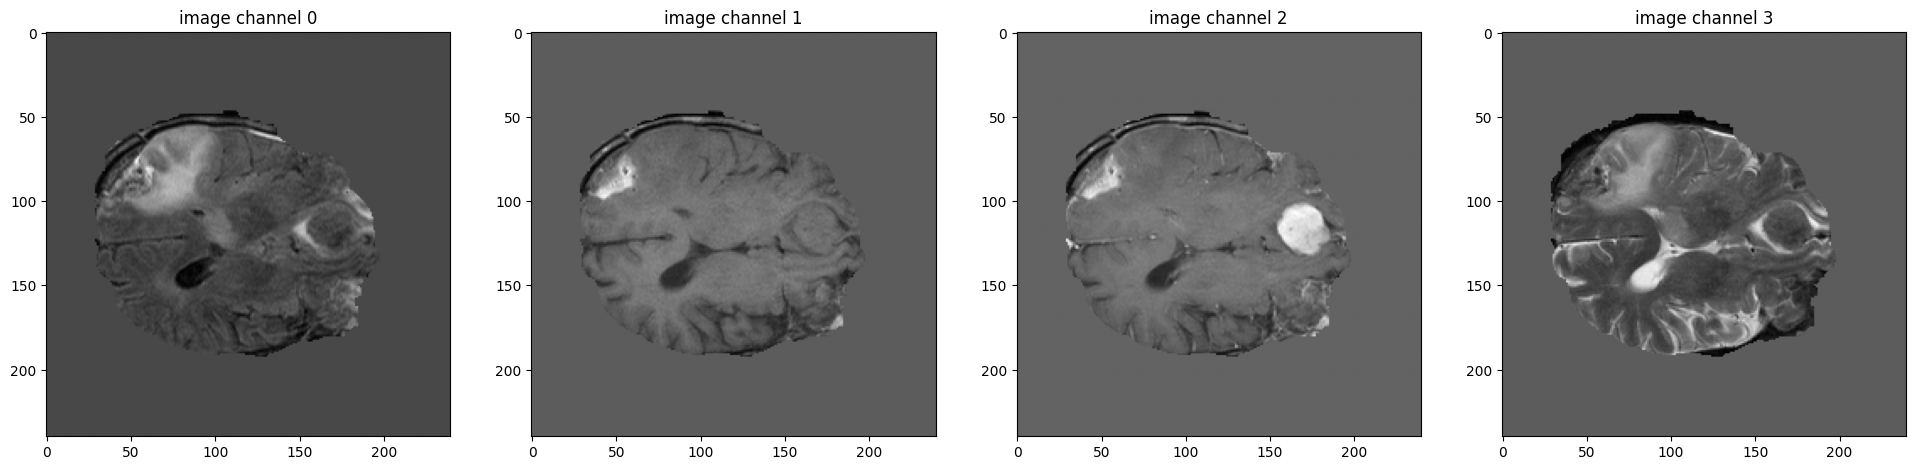

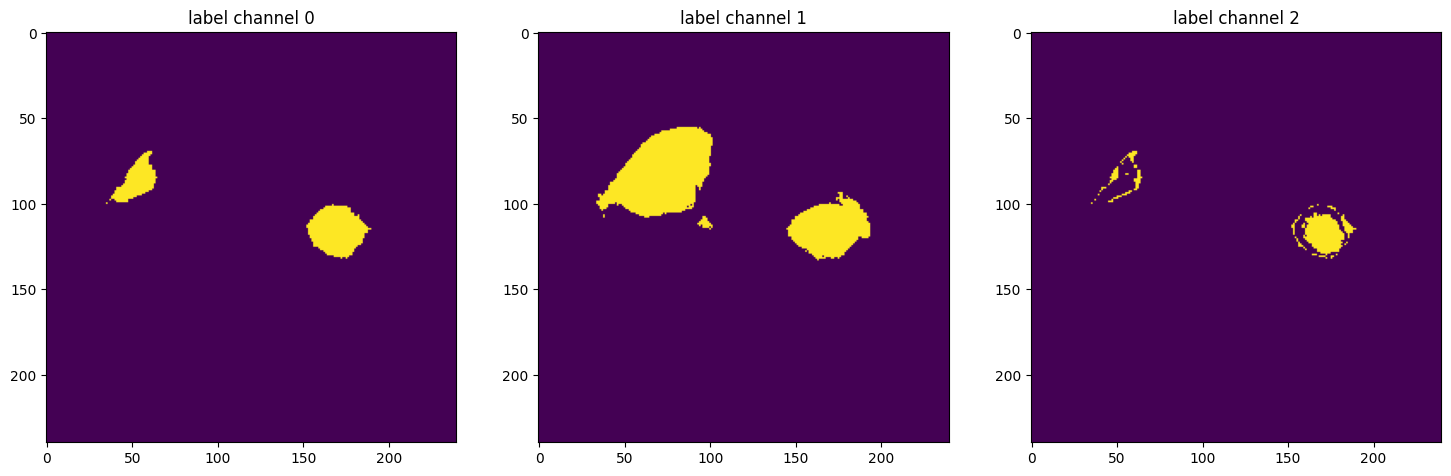

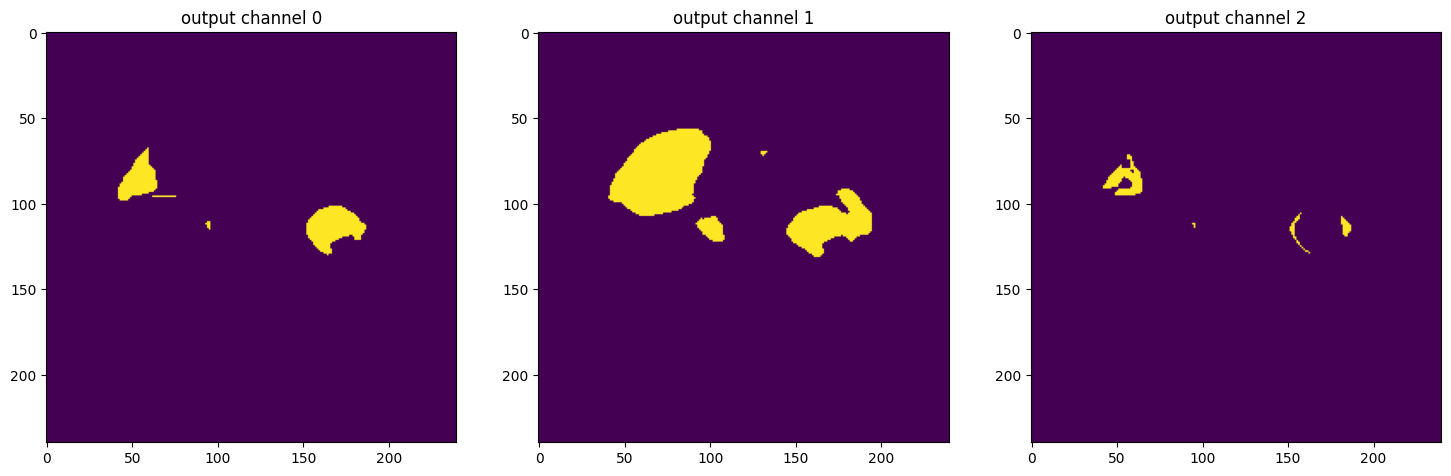

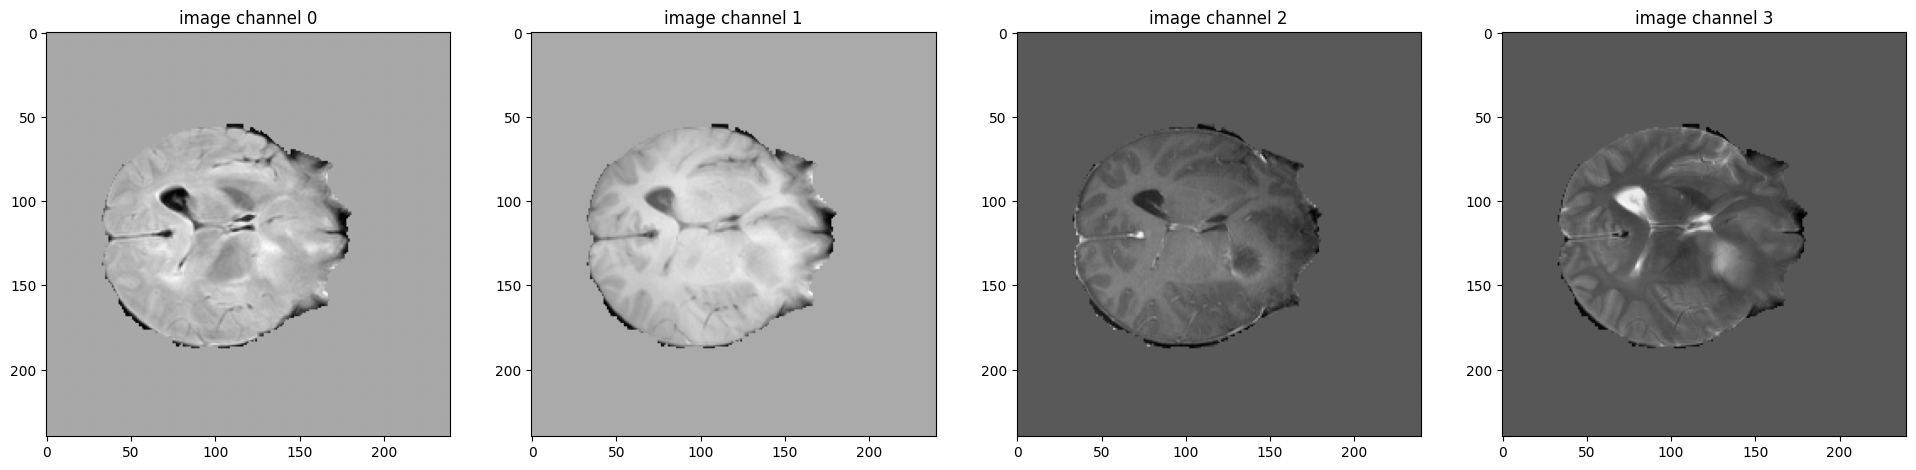

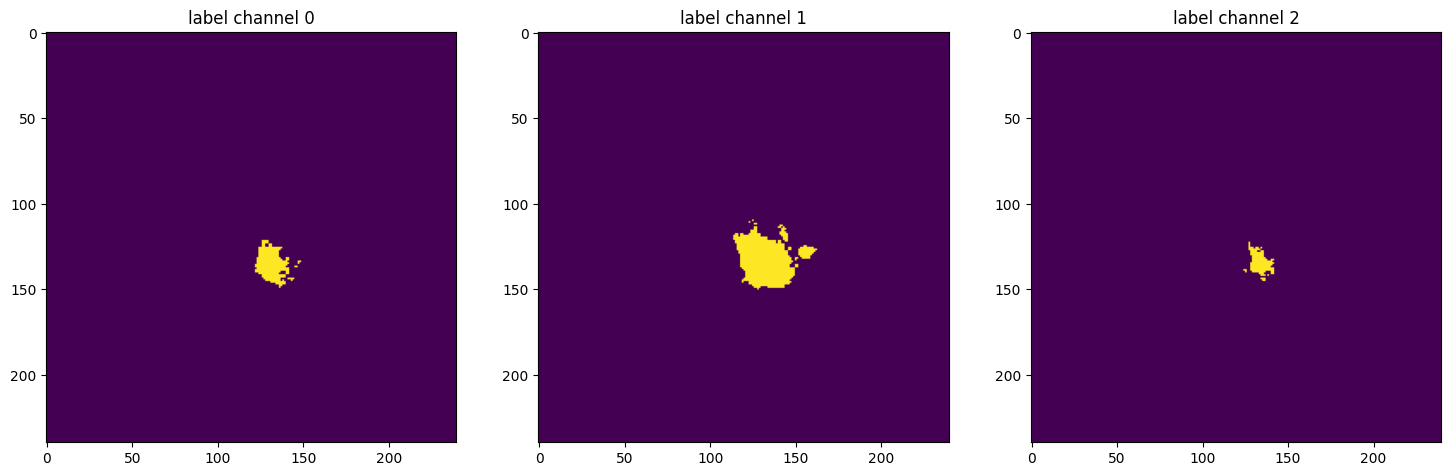

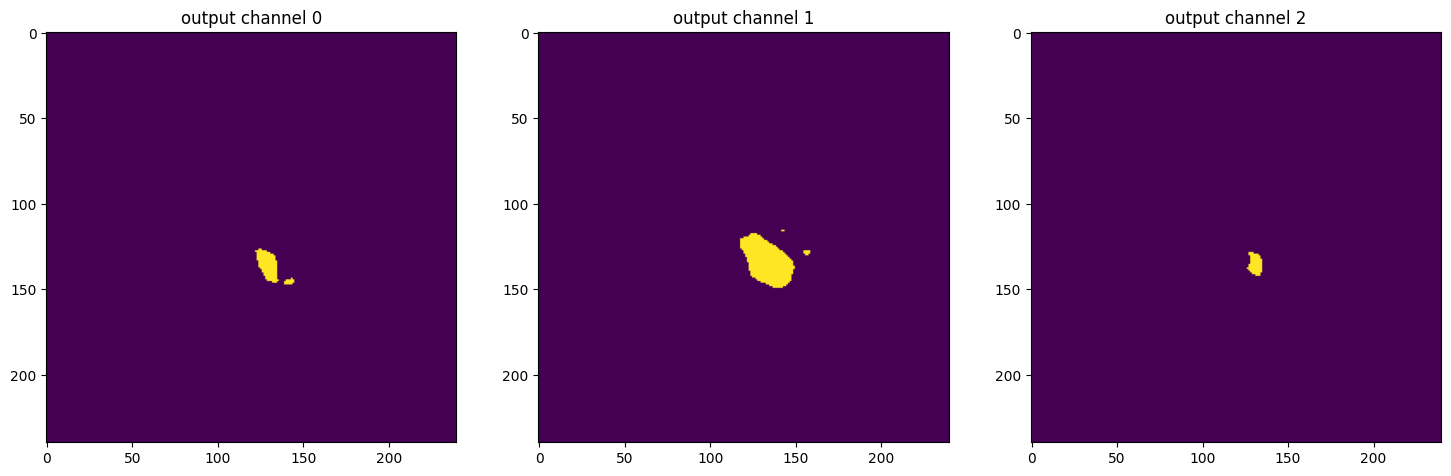

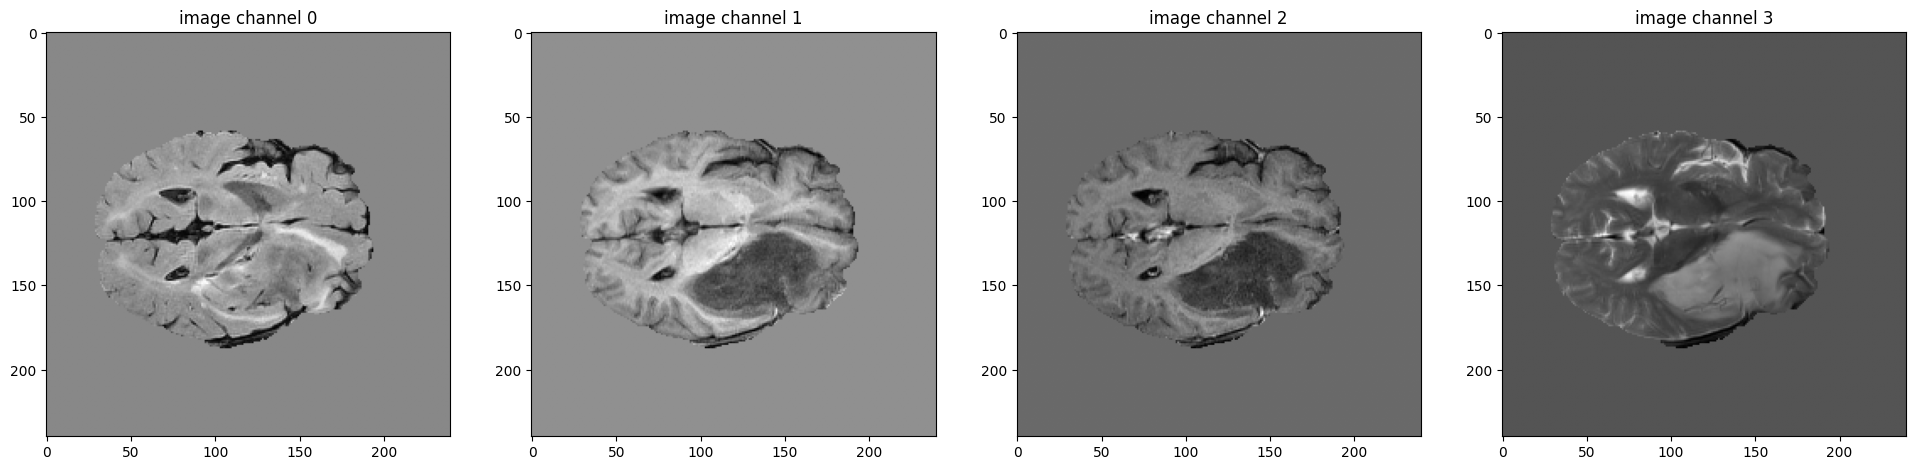

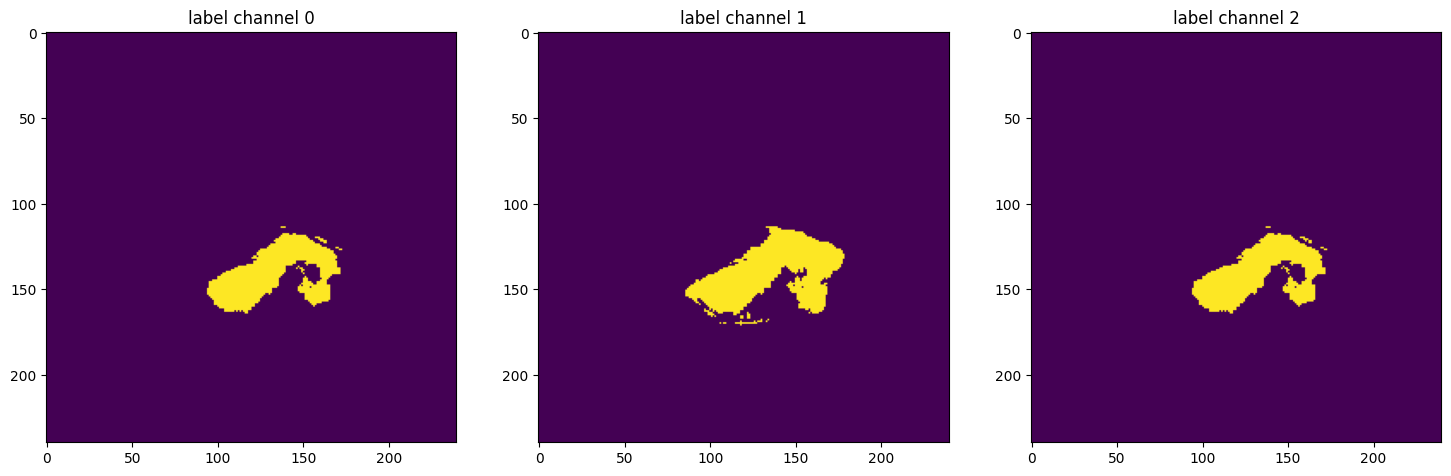

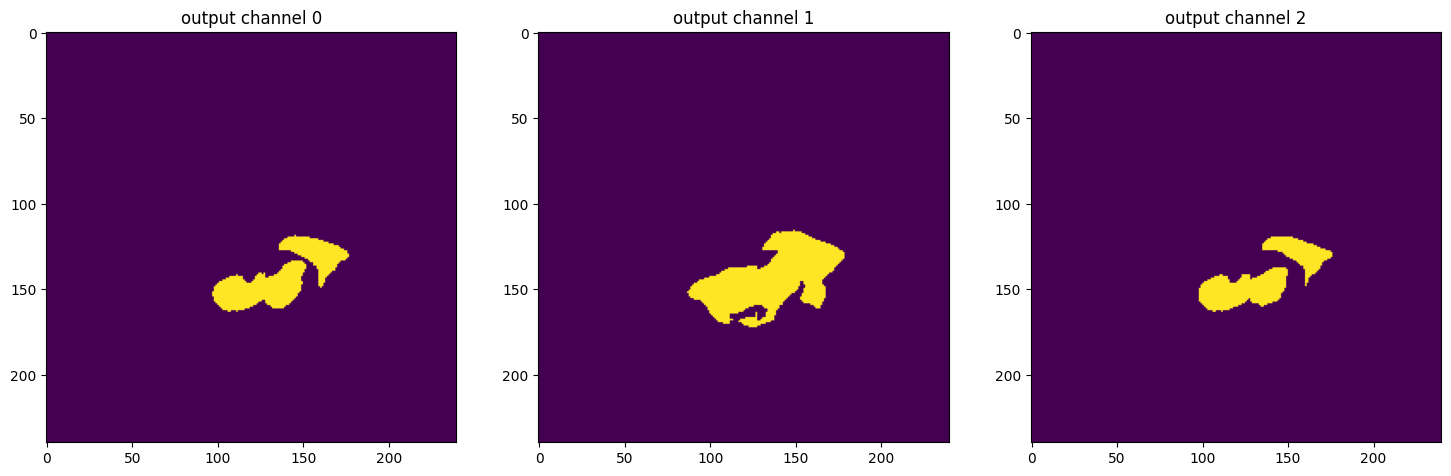

In [37]:
import random

rand_indexes = random.sample(range(len(test_ds)), k = 3)
for index in rand_indexes:
    visualize_model_mask(index)

## Metrics on test dataset

In [45]:
len(final_test_loader)

45

In [47]:
tc = []
wt = []
et = []
vals = []

model.eval()
with torch.inference_mode():
    for data in tqdm(final_test_loader, total = len(test_ds), desc = "Testing"):
        val_inputs, val_labels = (
            data["image"].to(device),
            data["label"].to(device)
        )
        val_outputs = inference(val_inputs)
        # Turn into those probabilities!
        val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
        dice_metric(y_pred = val_outputs, y = val_labels)                
        dice_metric_batch(y_pred = val_outputs, y = val_labels)
    
        del val_inputs, val_labels, val_outputs
    
        metric = dice_metric.aggregate().item()
        vals.append(metric)
    
        metric_batch = dice_metric_batch.aggregate()
        metric_tc = metric_batch[0].item()
        tc.append(metric_tc)  
                
        metric_wt = metric_batch[1].item()
        wt.append(metric_wt)
                
        metric_et = metric_batch[2].item()
        et.append(metric_et)
                
        dice_metric.reset()
        dice_metric_batch.reset()

Testing: 100%|██████████| 45/45 [03:26<00:00,  4.59s/it]


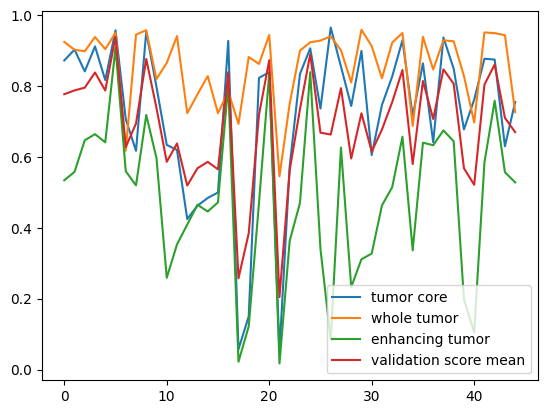

STATS 
 ----------
tumor core | mean dice 0.7236336314015919
whole tumor | mean dice 0.8573510540856255
enhancing tumor | mean dice 0.48699920686582726
avg dice | mean dice 0.6893279621998469


In [57]:
sns.lineplot(tc, label = "tumor core")
sns.lineplot(wt, label = "whole tumor")
sns.lineplot(et, label = "enhancing tumor")
sns.lineplot(vals, label = "validation score mean")
plt.show()
print("STATS \n", "-" * 10)

stats = {"tumor core": tc, "whole tumor": wt, "enhancing tumor": et, "avg dice": vals}
for name, data in stats.items():
    print(f"{name} | mean dice {np.array(data).mean()}")

# Convert to onnx model

In [ ]:
import torch.onnx

dummy_input = torch.randn(1, 4, 240, 240, 160).to(device) # volume size
onnx_path = Path("/kaggle/working/onnx")
onnx_path.mkdir(parents = True, exist_ok = True)
torch.onnx.export(model, dummy_input, onnx_path / "onnx_model.onnx", verbose=False)
print("DONE")

In [ ]:
import numpy as np 
sns.regplot(x = np.array(range(len(epoch_loss_values))), y = epoch_loss_values, scatter=False, color="red", label="Trend Line (Best Fit)") 
sns.lineplot(epoch_loss_values)
plt.show()